In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

import torch
import pickle
import numpy as np
from pathlib import Path
import sys

from learning import StateEncoder, initialize_encoder_random
from problems import GridworldProblem
from policies import GreedyPolicy
from omegaconf import OmegaConf
import copy
from typing import Optional, Callable, List
from experiments.load_model import load_model
import matplotlib.pyplot as plt

from planning import WaypointPlanner

In [11]:
def print_results(paths, epoch_min=0, epoch_lim=float('inf')):
    """
    Plot training metrics overlayed for multiple experiment paths.
    
    Args:
        paths: List of tuples (label, path) or list of paths (will use path as label)
        epoch_min: Minimum epoch to plot (default: 0)
        epoch_lim: Maximum epoch to plot (default: infinity)
    """
    # Normalize input to list of (label, path) tuples
    if isinstance(paths, list) and len(paths) > 0:
        if isinstance(paths[0], tuple):
            path_list = paths
        else:
            path_list = [(path, path) for path in paths]
    else:
        raise ValueError("paths must be a list of paths or list of (label, path) tuples")
    
    # Load all data
    all_data = []
    for label, path in path_list:
        model = load_model(path + '/model.pt')
        with open(path + '/results.pkl', 'rb') as file:
            results = pickle.load(file)
        with open(path + '/training_history.pkl', 'rb') as file:
            history = pickle.load(file)
        all_data.append((label, model, results, history))
        print(model['config'].env.gamma)
    
    # Print keys from first experiment
    # print("Results keys:", all_data[0][2].keys())   
    # print("History keys:", all_data[0][3].keys())
    for label, model, results, history in all_data:
        print(f"--- {label} ---")
        for key, value in results.items():
            print(f"{key}: {value}")
        print()    
    
    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    for label, model, results, history in all_data:
        epochs = np.arange(len(history['loss'])) * model['config'].training.learn_frequency
        mask = (epochs >= epoch_min) & (epochs <= epoch_lim)
        plt.plot(epochs[mask], np.array(history['loss'])[mask], label=label)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot Success Rate
    plt.figure(figsize=(10, 6))
    for label, model, results, history in all_data:
        epochs = np.arange(len(history['success_rate'])) * model['config'].training.eval_frequency
        mask = (epochs >= epoch_min) & (epochs <= epoch_lim)
        plt.plot(epochs[mask], np.array(history['success_rate'])[mask], label=label)
    plt.title('Success Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Success Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot Mean Path Length
    plt.figure(figsize=(10, 6))
    for label, model, results, history in all_data:
        epochs = np.arange(len(history['mean_path_length'])) * model['config'].training.eval_frequency
        mask = (epochs >= epoch_min) & (epochs <= epoch_lim)
        plt.plot(epochs[mask], np.array(history['mean_path_length'])[mask], label=label)
    plt.title('Mean Path Length')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Path Length')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot Mean Error
    plt.figure(figsize=(10, 6))
    for label, model, results, history in all_data:
        epochs = np.arange(len(history['mean_error'])) * model['config'].training.eval_frequency
        mask = (epochs >= epoch_min) & (epochs <= epoch_lim)
        plt.plot(epochs[mask], np.array(history['mean_error'])[mask], label=label)
    plt.title('Mean Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
def test_rollout(path, start=None, goal=None):
    model = load_model(path + '/model.pt', verbose=False)
    config = model['config']

    env = GridworldProblem(config.env.K, config.env.N, config.env.O, config.env.r, config.seed)
    # start_state, goal_state = env.reset()
    def s_encoder(state):
        """Encode state: A @ psi(state)"""
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            emb = model['psi_net'](state_tensor).squeeze(0).numpy()
            return model['A_np'] @ emb
    
    def g_encoder(state):
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            emb = model['psi_net'](state_tensor).squeeze(0).numpy()
            return emb
    policy = GreedyPolicy(env, s_encoder, model['config']['eval']['temperature'])
    planner = WaypointPlanner(start, goal, env, policy,
                          g_encoder, model['A_np'],
                          waypoint_type=model['config']['planner']['waypoint_type'],
                          max_waypoints=0)
    rollout, length, success = planner.rollout(start, goal, max_steps=model['config']['eval']['max_steps'], num_waypoints=0, temperature=0.1)
    # rollout, length, success = planner.rollout(start, goal, max_steps=model['config']['eval']['max_steps'], num_waypoints=0, temperature=model['config']['eval']['temperature'])
    return rollout, length, success

Successfully loaded model from: results/100x10_overfit_i/i_g99_1to0_c25_20k/model.pt
Configuration:
  Environment: K=100, N=10, O=0
  Model: latent_dim=64, hidden_dims=[64, 64]
  Waypoint type: i
  Seed: 123
0.99
Successfully loaded model from: results/100x10_overfit_i/i_g99_1to0_c1/model.pt
Configuration:
  Environment: K=100, N=10, O=0
  Model: latent_dim=64, hidden_dims=[64, 64]
  Waypoint type: i
  Seed: 123
0.99
Successfully loaded model from: results/100x10_overfit_i/i_g99_1to0/model.pt
Configuration:
  Environment: K=100, N=10, O=0
  Model: latent_dim=64, hidden_dims=[64, 64]
  Waypoint type: i
  Seed: 123
0.99
Successfully loaded model from: results/100x10_overfit_i/i_g99_1to0_c1_20k/model.pt
Configuration:
  Environment: K=100, N=10, O=0
  Model: latent_dim=64, hidden_dims=[64, 64]
  Waypoint type: i
  Seed: 123
0.99
Successfully loaded model from: results/100x10_overfit_i/i_g9_75to02_c25/model.pt
Configuration:
  Environment: K=100, N=10, O=0
  Model: latent_dim=64, hidden_di

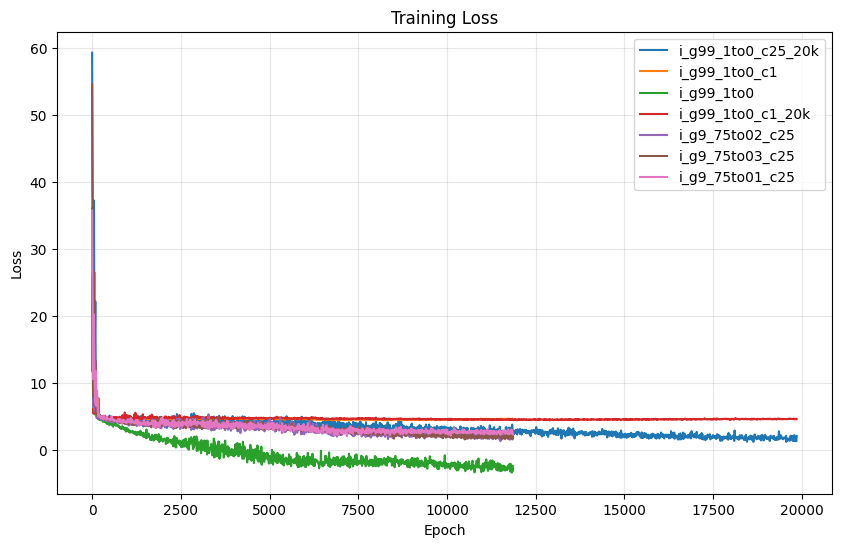

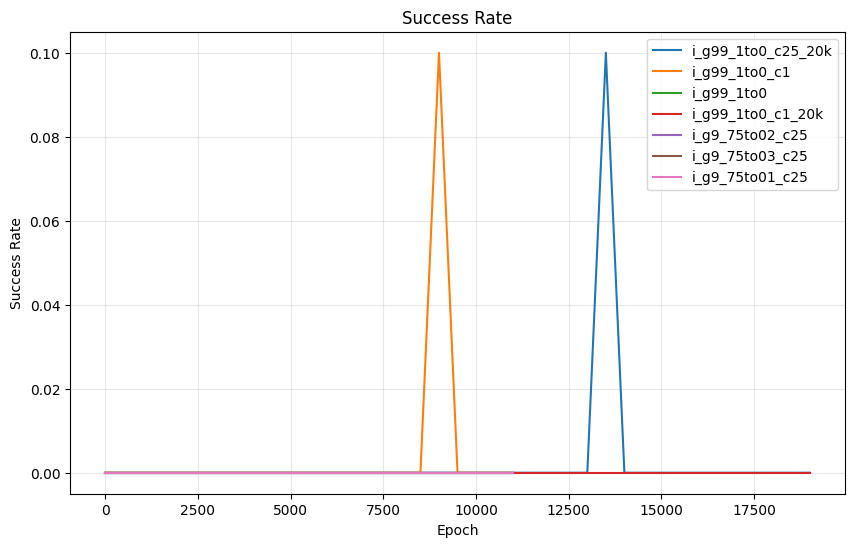

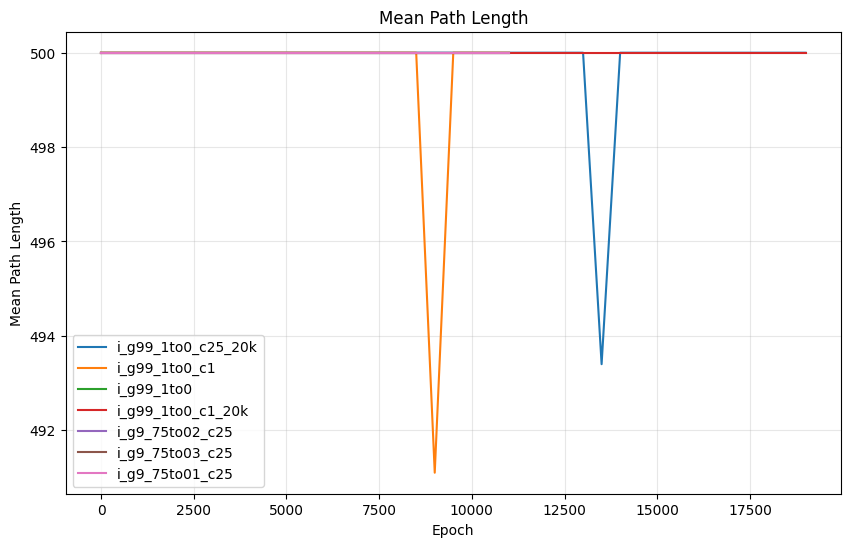

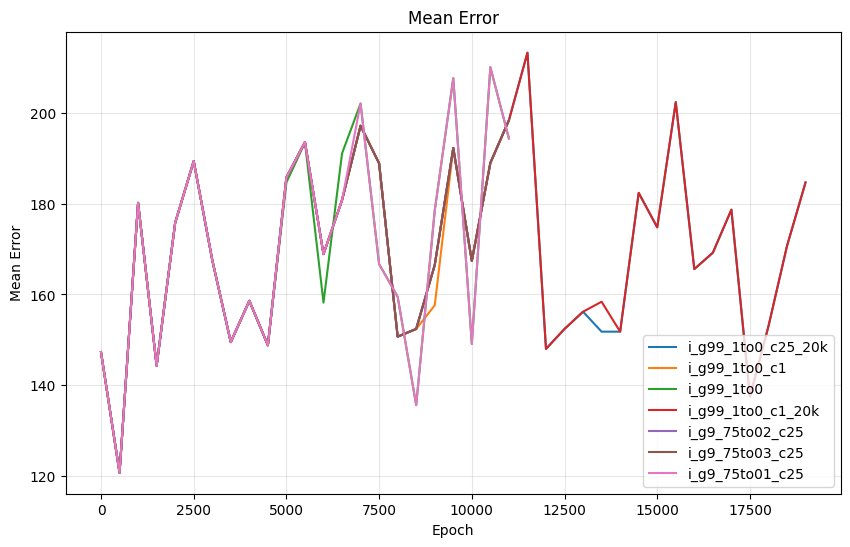

In [22]:
# Compare all three experiments with labels
# experiment dirs

# problem = '100x5_t_opt'
# problem = '100x5_t_g999_YAY'
# problem = '50x5'
# problem = '100x2_t_g999'
# # problem = '100x2_old'
# # i_path = 'results/50x5/i'
# # c_path = 'results/50x5/c'
# # n_path = 'results/50x5/n'
# problem = '100x10_opt'
# i_path = f'results/{problem}/i'
# c_path_10 = f'results/{problem}/c_10'
# c_path_100 = f'results/{problem}/c_100'
# n_path = f'results/{problem}/n'

# loggers = [
#     ('i-planning', i_path),
    # ('c-planning (m=10)', c_path_10),
    # ('c-planning (m=100)', c_path_100),
    # ('n-planning', n_path),
# ]

i_overfit_path = 'results/100x10_overfit_i/'
loggers = []
for file in Path(i_overfit_path).iterdir():
    if file.is_dir():
        loggers.append((file.name, str(file)))
# print_results(loggers, epoch_min=7500, epoch_lim=17500)
print_results(loggers)

In [19]:
# Test rollouts
from tqdm import tqdm
results = []
lengths = []
errors = []

# Initialize data structures for each logger
for label, path in loggers:
    results.append((label, []))
    lengths.append((label, []))
    errors.append((label, []))

# Iterate over test cases, evaluating all loggers on same start/goal
for k in tqdm(range(1000)):
    start = np.random.randint(0, 100, size=(5, ))
    goal = np.random.randint(0, 100, size=(5, ))
    
    # Evaluate all loggers on this same start/goal pair
    for idx, (label, path) in enumerate(loggers):
        rollout, length, success = test_rollout(path, start, goal) 
        manhattan_dist = np.abs(start-goal).sum()
        error = length - manhattan_dist
        
        results[idx][1].append(success) 
        lengths[idx][1].append(length)
        errors[idx][1].append((manhattan_dist, error))

  0%|          | 0/1000 [00:00<?, ?it/s]



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 10x64)

KeyError: 'n-planning'

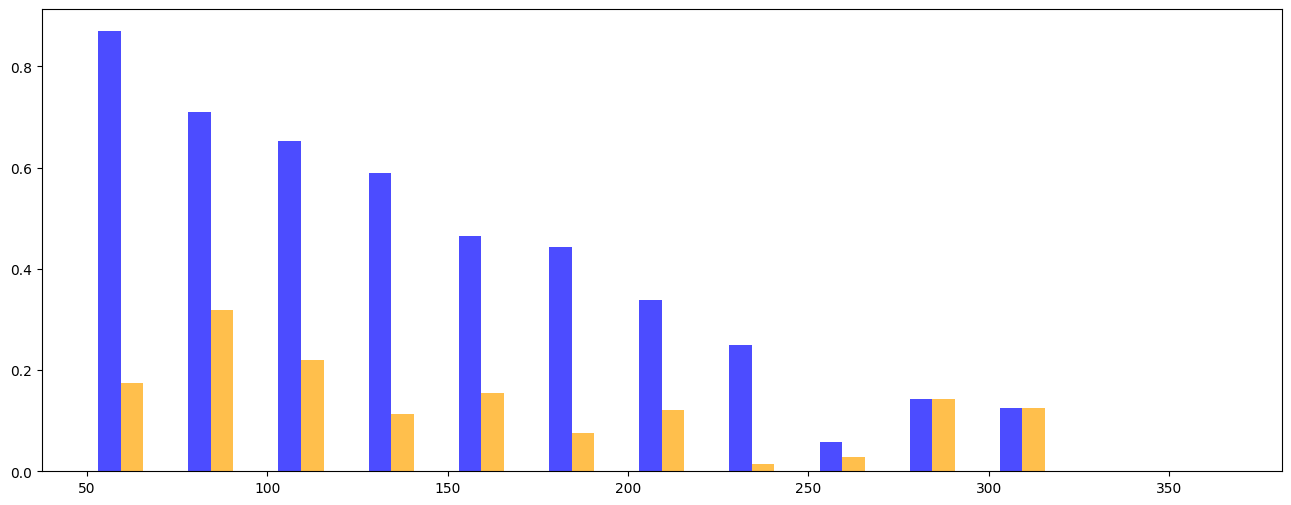

In [20]:
# Success rate by Manhattan distance bins (100-wide bins)
# Collect all Manhattan distances to determine range
all_manhattan_dists = []
for label, error_list in errors:
    for manhattan_dist, _ in error_list:
        all_manhattan_dists.append(manhattan_dist)

# Create bins of width 50 starting from 50
min_dist = 50
max_dist = max(all_manhattan_dists)
bin_width = 25
bin_edges = np.arange(min_dist, max_dist + bin_width, bin_width)
num_bins = len(bin_edges) - 1
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate success rate for each label in each bin
success_rates_by_bin = {}
counts_by_bin = {}
for idx, (label, result_list) in enumerate(results):
    success_rates = []
    counts = []
    for i in range(num_bins):
        # Find all samples in this bin
        bin_successes = []
        for j, (manhattan_dist, _) in enumerate(errors[idx][1]):
            if bin_edges[i] <= manhattan_dist < bin_edges[i+1]:
                bin_successes.append(result_list[j])
        
        # Calculate success rate for this bin
        if len(bin_successes) > 0:
            success_rates.append(np.mean(bin_successes))
            counts.append(len(bin_successes))
        else:
            success_rates.append(np.nan)  # No data in this bin
            counts.append(0)
    
    success_rates_by_bin[label] = success_rates
    counts_by_bin[label] = counts

# Plot bar graph
fig, ax = plt.subplots(figsize=(16, 6))

# Width of bars and positions
bar_width_plot = bin_width / (len(loggers) + 1)
colors = ['blue', 'orange', 'green', 'red', 'purple']

for idx, (label, _) in enumerate(loggers):
    offsets = bar_width_plot * (idx - len(loggers)/2 + 0.5)
    positions = bin_centers + offsets
    rates = success_rates_by_bin[label]
    
    # Only plot bars where we have data
    valid_positions = [pos for pos, rate in zip(positions, rates) if not np.isnan(rate)]
    valid_rates = [rate for rate in rates if not np.isnan(rate)]
    
    ax.bar(valid_positions, valid_rates, width=bar_width_plot, 
           label=label, alpha=0.7, color=colors[idx % len(colors)])

ax.set_xlabel('Manhattan Distance')
ax.set_ylabel('Success Rate')
ax.set_title(f'Success Rate by Manhattan Distance ({bin_width}-wide bins, starting from {min_dist})')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print bin counts for debugging
print("Samples per bin:")
for i in range(num_bins):
    if any(counts_by_bin[label][i] > 0 for label, _ in loggers):
        bin_range = f"[{bin_edges[i]:.0f}, {bin_edges[i+1]:.0f})"
        counts_str = ", ".join([f"{label}: {counts_by_bin[label][i]}" for label, _ in loggers])
        print(f"  {bin_range}: {counts_str}")


In [204]:
successes = []
for i in range(100):
    start = np.random.randint(0, 100, size=(2,))
    goal = np.random.randint(0, 100, size=(2,))
    rollout, length, success = test_rollout(c_path, start=start, goal=goal)
    print(start, goal, success)
    successes.append(success)
print(f"Random Start/Goal Success Rate: {np.mean(successes):.3f}")

[53 26] [35 97] False
[71 21] [88 99] True
[96 72] [12 73] True
[ 4 26] [88 92] True
[13 79] [81 66] True
[1 6] [ 0 19] True
[44 19] [27  0] True
[13  9] [62 82] True
[13 89] [18 67] True
[35 40] [74 39] True
[70 49] [60 56] True
[84 41] [17 16] True
[20 30] [ 1 14] True
[78 80] [92 87] True
[69 90] [70 10] True
[58 30] [68 83] True
[68 83] [ 7 86] True
[93 60] [20 85] True
[62 35] [69 27] True
[61 89] [76 81] True
[39 81] [11 86] True
[58 82] [ 0 34] True
[92 60] [30 68] True
[68 74] [23 31] True
[75 82] [71 39] True
[54 37] [16  5] True
[79 23] [37 38] True
[51 33] [42 50] True
[89 95] [98 94] True
[34 11] [49 36] True
[42 54] [70 33] True
[ 6 86] [68 63] True
[14  9] [40 47] True
[77 63] [ 8 36] True
[44 11] [82 17] True
[60 76] [72 25] True
[93 60] [20 85] True
[62 35] [69 27] True
[61 89] [76 81] True
[39 81] [11 86] True
[58 82] [ 0 34] True
[92 60] [30 68] True
[68 74] [23 31] True
[75 82] [71 39] True
[54 37] [16  5] True
[79 23] [37 38] True
[51 33] [42 50] True
[89 95] [98 94

In [210]:
start = np.array([0, 0])
goal = np.array([99, 99])

rollout, length, success = test_rollout(c_path, start=start, goal=goal)
print(f"Rollout from {start} to {goal}: Length = {length}, Success = {success}")

Rollout from [0 0] to [99 99]: Length = 232, Success = True


In [16]:
# Waypoint Eval
from waypoints import c_waypoint, i_waypoint

def waypoint_mse(path, waypoint_type = None, M=None, c=None):
    model = load_model(path + '/model.pt', verbose=False)
    config = model['config']

    env = GridworldProblem(config.env.K, config.env.N, config.env.O, config.env.r, config.seed)
    # start_state, goal_state = env.reset()
    def s_encoder(state):
        """Encode state: A @ psi(state)"""
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            emb = model['psi_net'](state_tensor).squeeze(0).numpy()
            return model['A_np'] @ emb
    
    def g_encoder(state):
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            emb = model['psi_net'](state_tensor).squeeze(0).numpy()
            return emb
    policy = GreedyPolicy(env, s_encoder, model['config']['eval']['temperature'])
    mses = []
    # build state buffer first 
    if waypoint_type is None:
        waypoint_type = model['config']['planner']['waypoint_type']
    if M is None:
        M = config.planner.M
    if c is None:
        c = config.training.c_target
    state_buffer = []
    if waypoint_type == 'c':
        while len(state_buffer) < config.training.buffer_size:
            start = np.random.randint(0, config.env.K, size=(config.env.N,))
            goal = np.random.randint(0, config.env.K, size=(config.env.N,))
            planner = WaypointPlanner(start, goal, env, policy,
                            g_encoder, model['A_np'],
                            waypoint_type=config.planner.waypoint_type,
                            max_waypoints=0)
            rollout, length, success = planner.rollout(start, goal, max_steps=model['config']['eval']['max_steps'], num_waypoints=0, temperature=0.1)
            state_buffer.extend(rollout)
    for t in tqdm(range(100)):
        start = np.random.randint(0, config.env.K, size=(config.env.N,))
        goal = np.random.randint(0, config.env.K, size=(config.env.N,))
       
        # start = np.array([10, 10])
        # start = np.array([80, 80])
        # rnga = planner.get_waypoints(start, goal)
        if waypoint_type == 'c':
            wp = c_waypoint(
                        start, goal, g_encoder, model['A_np'],
                        state_buffer, M, config.planner.waypoint_temp)
        elif waypoint_type == 'i':
            wp = i_waypoint(start, goal, g_encoder, model['A_np'], config.training.c_target)
        planner = WaypointPlanner(start, goal, env, policy,
                          g_encoder, model['A_np'],
                          waypoint_type=config.planner.waypoint_type,
                          max_waypoints=0)
        rollout, length, success = planner.rollout(start, goal, max_steps=model['config']['eval']['max_steps'], num_waypoints=0, temperature=0.1)
        mses.append(min([np.linalg.norm(g_encoder(point) - wp, ord=2)**2 for point in rollout]))
    
    plt.hist(mses, bins=30)
    plt.title('Waypoint MSE Distribution')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    return mses
            



    

100%|██████████| 100/100 [00:06<00:00, 14.35it/s]



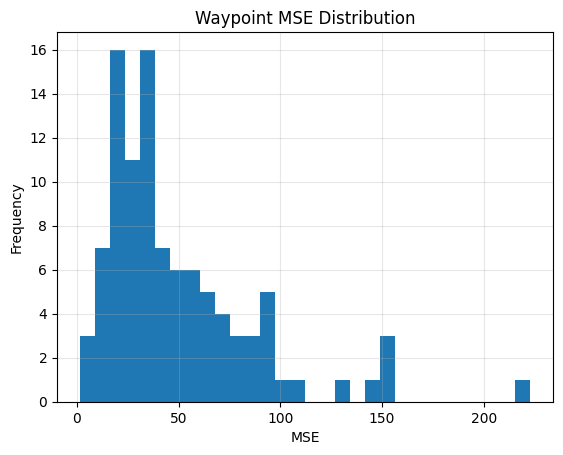

In [137]:
c_mses = waypoint_mse(c_path)

100%|██████████| 100/100 [00:06<00:00, 16.66it/s]



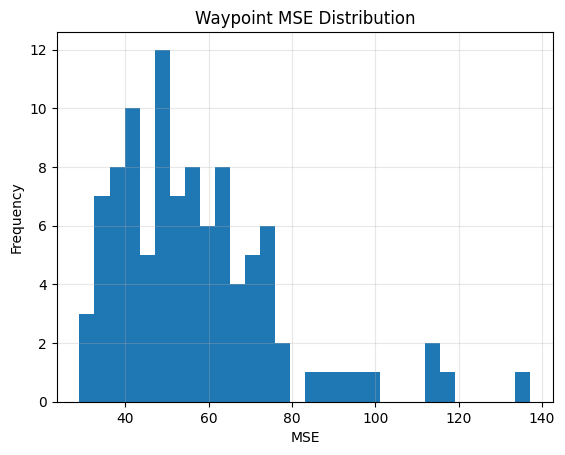

In [138]:
i_mses = waypoint_mse(i_path)

In [127]:
print(np.array(c_mses).mean())
print(np.array(i_mses).mean())

47.81278
51.0366792965453


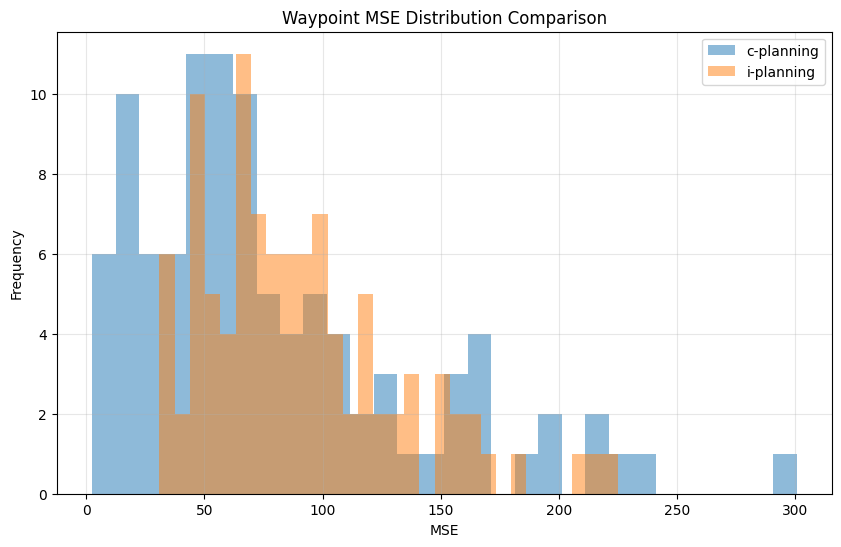

In [272]:
# layer the histograms together
plt.figure(figsize=(10, 6))
plt.hist(c_mses, bins=30, alpha=0.5, label='c-planning')
plt.hist(i_mses, bins=30, alpha=0.5, label='i-planning')
plt.title('Waypoint MSE Distribution Comparison')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
c_mses_n_10 = waypoint_mse(n_path, waypoint_type='c', M=10)
c_mses_n_100 = waypoint_mse(n_path, waypoint_type='c', M=100)
c_mses_n_1000 = waypoint_mse(n_path, waypoint_type='c', M=1000)

NameError: name 'tqdm' is not defined

100%|██████████| 100/100 [00:08<00:00, 11.62it/s]



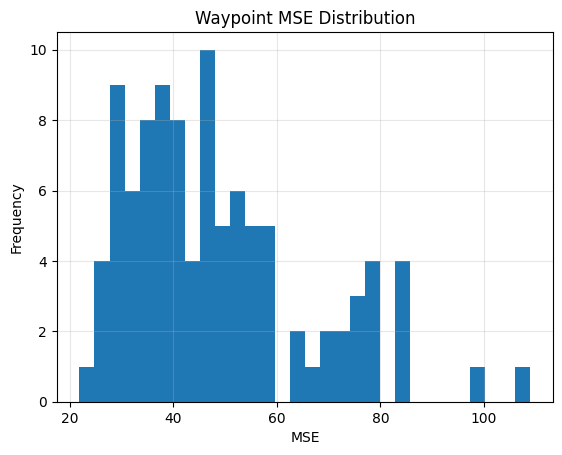

In [143]:
i_mses_n = waypoint_mse(n_path, waypoint_type='i', c=10)

In [144]:
print(f"C-Planner Waypoint MSE: Mean = {np.mean(c_mses_n_10):.4f}, Std = {np.std(c_mses_n_10):.4f}")
print(f"C-Planner Waypoint MSE: Mean = {np.mean(c_mses_n_100):.4f}, Std = {np.std(c_mses_n_100):.4f}")
print(f"C-Planner Waypoint MSE: Mean = {np.mean(c_mses_n_1000):.4f}, Std = {np.std(c_mses_n_1000):.4f}")
print(f"I-Planner Waypoint MSE: Mean = {np.mean(i_mses_n):.4f}, Std = {np.std(i_mses_n):.4f}")

C-Planner Waypoint MSE: Mean = 49.9034, Std = 39.6675
C-Planner Waypoint MSE: Mean = 24.6169, Std = 18.4729
C-Planner Waypoint MSE: Mean = 24.8639, Std = 16.4922
I-Planner Waypoint MSE: Mean = 48.5821, Std = 17.8295


100
100
100
100


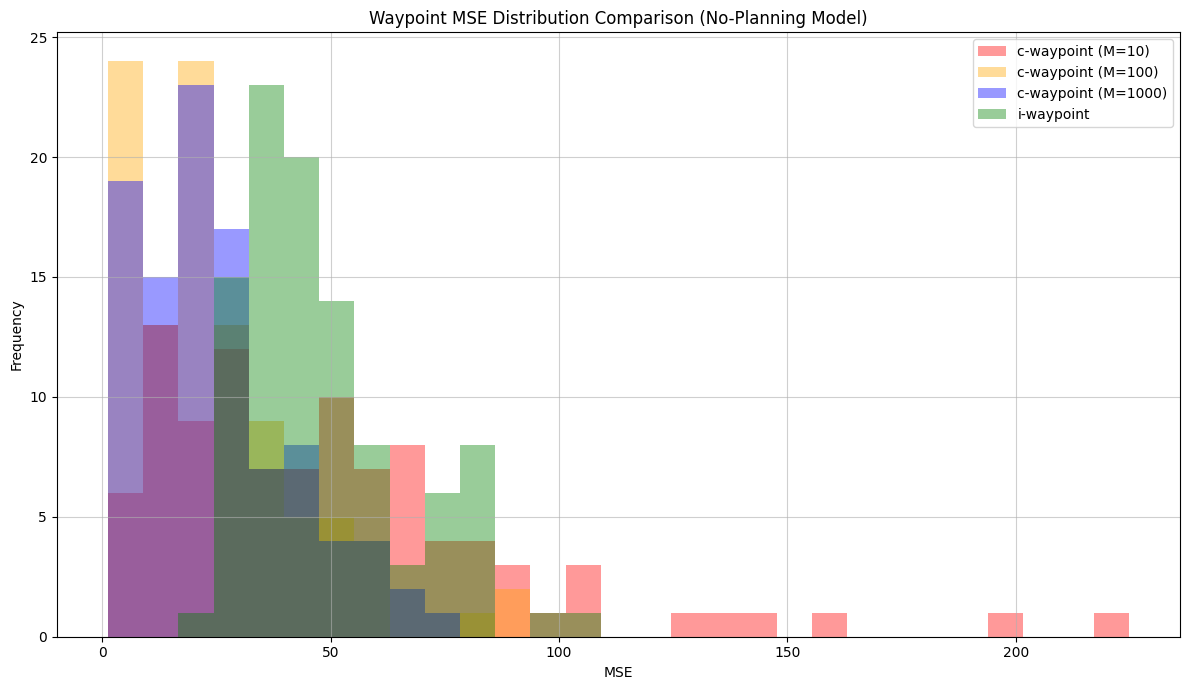

Summary Statistics:
c-waypoint (M=10):   Mean = 49.9034, Std = 39.6675
c-waypoint (M=100):  Mean = 24.6169, Std = 18.4729
c-waypoint (M=1000): Mean = 24.8639, Std = 16.4922
i-waypoint:          Mean = 48.5821, Std = 17.8295


In [147]:
# Create overlayed histogram comparing all waypoint MSE distributions
plt.figure(figsize=(12, 7))
print(len(c_mses_n_10))
print(len(c_mses_n_100))
print(len(c_mses_n_1000))
print(len(i_mses_n))

# Find common bin range across all datasets
all_data = c_mses_n_10 + c_mses_n_100 + c_mses_n_1000 + i_mses_n
bin_min = min(all_data)
bin_max = max(all_data)
bins = np.linspace(bin_min, bin_max, 30)

plt.hist(c_mses_n_10, bins=bins, alpha=0.4, label='c-waypoint (M=10)', color='red')
plt.hist(c_mses_n_100, bins=bins, alpha=0.4, label='c-waypoint (M=100)', color='orange')
plt.hist(c_mses_n_1000, bins=bins, alpha=0.4, label='c-waypoint (M=1000)', color='blue')
plt.hist(i_mses_n, bins=bins, alpha=0.4, label='i-waypoint', color='green')
plt.title('Waypoint MSE Distribution Comparison (No-Planning Model)')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(f"c-waypoint (M=10):   Mean = {np.mean(c_mses_n_10):.4f}, Std = {np.std(c_mses_n_10):.4f}")
print(f"c-waypoint (M=100):  Mean = {np.mean(c_mses_n_100):.4f}, Std = {np.std(c_mses_n_100):.4f}")
print(f"c-waypoint (M=1000): Mean = {np.mean(c_mses_n_1000):.4f}, Std = {np.std(c_mses_n_1000):.4f}")
print(f"i-waypoint:          Mean = {np.mean(i_mses_n):.4f}, Std = {np.std(i_mses_n):.4f}")

In [39]:
# waypoint dist vis
from tqdm import tqdm

def waypoint_dist_vis2D(path, waypoint_type, start_state, goal_state, M=None):
    model = load_model(path + '/model.pt', verbose=False)
    config = model['config']
    if config.env.N != 2:
        print("Environment is not 2D. Cannot visualize waypoint distribution.")
        return
    env = GridworldProblem(config.env.K, config.env.N, config.env.O, config.env.r, config.seed)
    # start_state, goal_state = env.reset()
    def s_encoder(state):
        """Encode state: A @ psi(state)"""
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            emb = model['psi_net'](state_tensor).squeeze(0).numpy()
            return model['A_np'] @ emb
    
    def g_encoder(state):
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            emb = model['psi_net'](state_tensor).squeeze(0).numpy()
            return emb
    policy = GreedyPolicy(env, s_encoder, model['config']['eval']['temperature'])
    mses = []
    # build state buffer first 
    if waypoint_type is None:
        waypoint_type = model['config']['planner']['waypoint_type']
        
    state_buffer = []
    if waypoint_type == 'c':
        while len(state_buffer) < config.training.buffer_size:
            start = np.random.randint(0, config.env.K, size=(config.env.N,))
            goal = np.random.randint(0, config.env.K, size=(config.env.N,))
            planner = WaypointPlanner(start, goal, env, policy,
                            g_encoder, model['A_np'],
                            waypoint_type=waypoint_type,
                            max_waypoints=0)
            rollout, length, success = planner.rollout(start, goal, max_steps=model['config']['eval']['max_steps'], num_waypoints=0, temperature=0.1)
            state_buffer.extend(rollout)
    if waypoint_type == 'i':
        c = config.training.c_target
        c = 10
        A = model['A_np']
        sigma_inv = (c/(c+1)) * (A.T @ A) + ((c+1)/c) * np.eye(A.shape[1])
        sigma = np.linalg.inv(sigma_inv)
    buckets = np.zeros((config.env.K, config.env.K))
    psi_inv = np.zeros((config.env.K, config.env.K, config.model.k))
    for i in range(config.env.K):
        for j in range(config.env.K):
            point = np.array([i, j])
            psi_inv[i, j] = g_encoder(point)
    
    # Generate waypoints and find nearest points
    num_samples = 1000
    if M is None:
        M = config.planner.M
    for t in tqdm(range(num_samples), desc="Generating waypoints"):
        # Generate waypoint
        if waypoint_type == 'c':
            wp = c_waypoint(
                start_state, goal_state, g_encoder, model['A_np'],
                state_buffer, M, config.planner.waypoint_temp)
        elif waypoint_type == 'i':
            wp = i_waypoint(start_state, goal_state, g_encoder, model['A_np'], config.training.c_target, sigma=sigma)
        
        # Find point using psi_inv
        min_dist = float('inf')
        min_point = None
        for x in range(config.env.K):
            for y in range(config.env.K):
                dist = np.linalg.norm(psi_inv[x, y] - wp, ord=2)
                if dist < min_dist:
                    min_dist = dist
                    min_point = (x, y)
        buckets[min_point] += 1
    
    # Visualize the waypoint distribution as a heatmap
    # plt.figure(figsize=(10, 8))
    # plt.imshow(buckets.T, origin='lower', cmap='hot', interpolation='nearest')
    # plt.colorbar(label='Waypoint Count')
    # plt.scatter([start_state[0]], [start_state[1]], c='blue', s=200, marker='o', edgecolors='white', linewidths=2, label='Start')
    # plt.scatter([goal_state[0]], [goal_state[1]], c='green', s=200, marker='*', edgecolors='white', linewidths=2, label='Goal')
    # plt.title(f'Waypoint Distribution Heatmap ({waypoint_type}-waypoint)\nStart: {start_state}, Goal: {goal_state}')
    # plt.xlabel('X Coordinate')
    # plt.ylabel('Y Coordinate')
    # plt.legend(loc='upper left', framealpha=0.9)
    # plt.grid(True, alpha=0.3, color='white', linewidth=0.5)
    # plt.tight_layout()
    # plt.show()
    
    rollouts = []
    
    for t in tqdm(range(5), desc="Generating rollouts for overlay"):
        rollout, length, success = test_rollout(path, start=start_state, goal=goal_state)
        rollouts.append(rollout)
    # Collect all rollouts first
    plt.figure(figsize=(10, 8))

# --- First: draw rollouts (underneath) ---
    colors = ['cyan', 'magenta', 'yellow', 'orange', 'lime']
    for i, rollout in enumerate(rollouts):
        rollout_array = np.array(rollout)
        plt.plot(
            rollout_array[:, 0], rollout_array[:, 1],
            marker='o', color=colors[i % len(colors)],
            alpha=0.2,                     # ← more transparent rollouts
            label=f'Rollout {i+1}', linewidth=1, markersize=2
        )

    # --- Then: draw heatmap (on top, solid) ---
    plt.imshow(buckets.T, origin='lower', cmap='hot',
            interpolation='nearest', alpha=1.0)   # ← solid heatmap

    plt.colorbar(label='Waypoint Count')

    # Start/Goal markers remain on top
    plt.scatter([start_state[0]], [start_state[1]], c='blue', s=200,
                marker='o', edgecolors='white', linewidths=2, label='Start')
    plt.scatter([goal_state[0]], [goal_state[1]], c='green', s=200,
                marker='*', edgecolors='white', linewidths=2, label='Goal')

    plt.title(f'All Rollout Paths Overlay ({waypoint_type}-waypoint)\nStart: {start_state}, Goal: {goal_state}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left', framealpha=0.9)
    plt.grid(True, alpha=0.3, color='white', linewidth=0.5)
    plt.tight_layout()
    plt.show()
        
    
    return buckets

Generating rollouts for overlay: 100%|██████████| 5/5 [00:00<00:00, 73.34it/s]



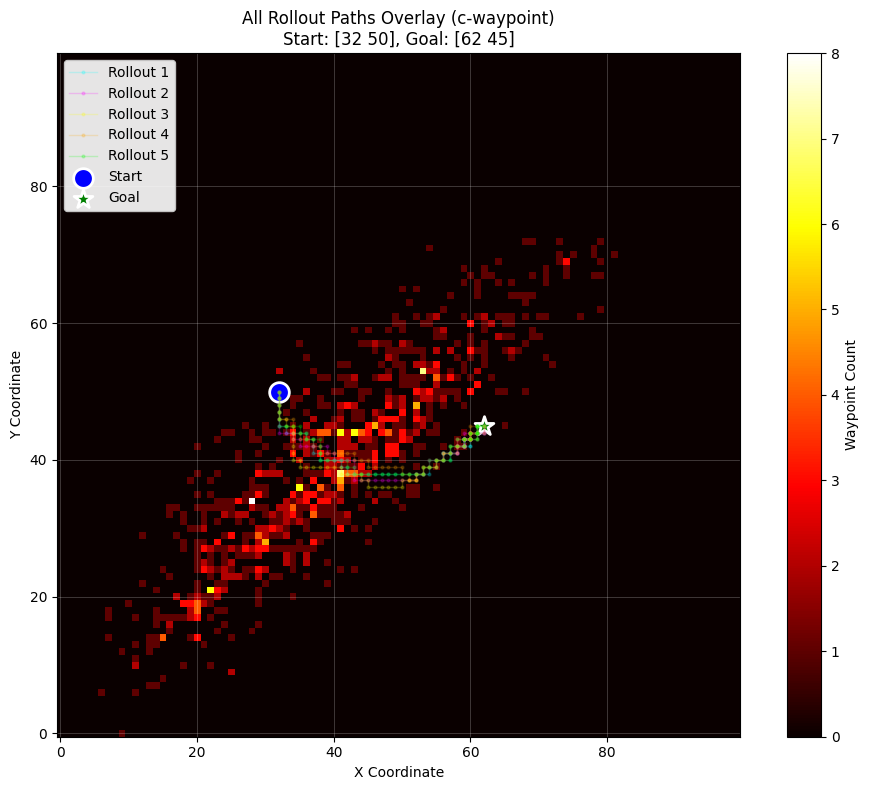

Generating rollouts for overlay: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]



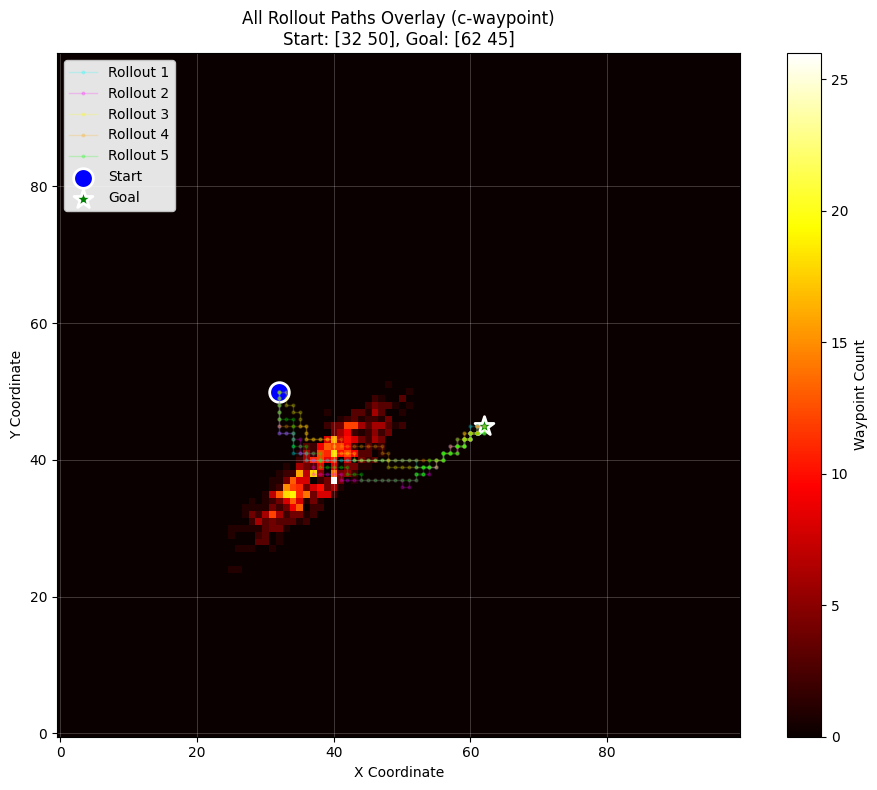

Generating rollouts for overlay: 100%|██████████| 5/5 [00:00<00:00, 73.80it/s]



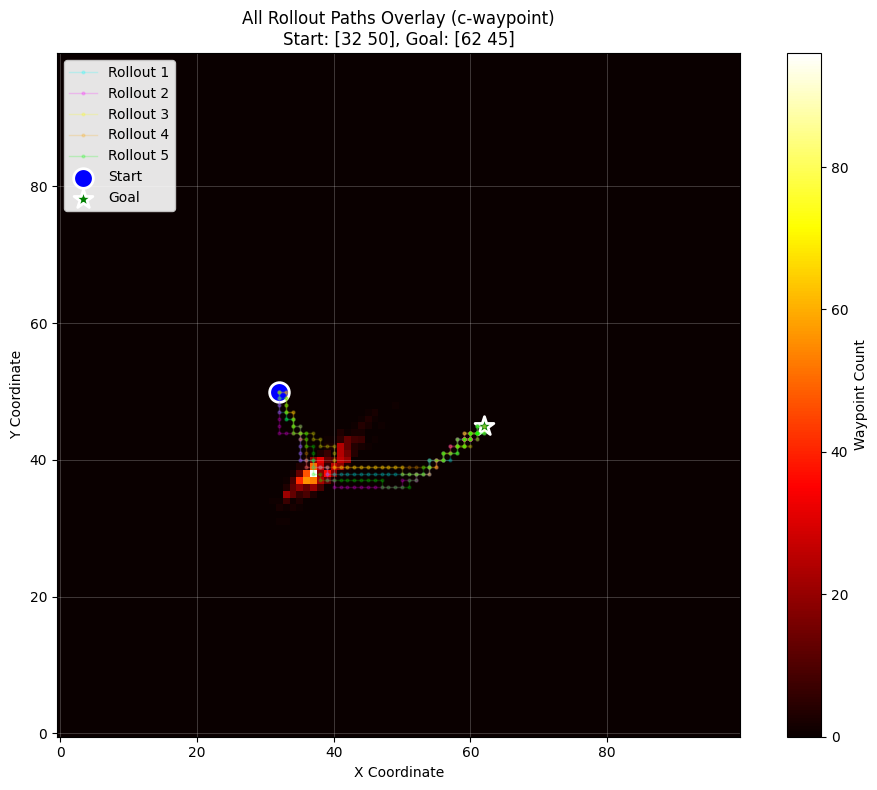

Generating rollouts for overlay: 100%|██████████| 5/5 [00:00<00:00, 76.55it/s]



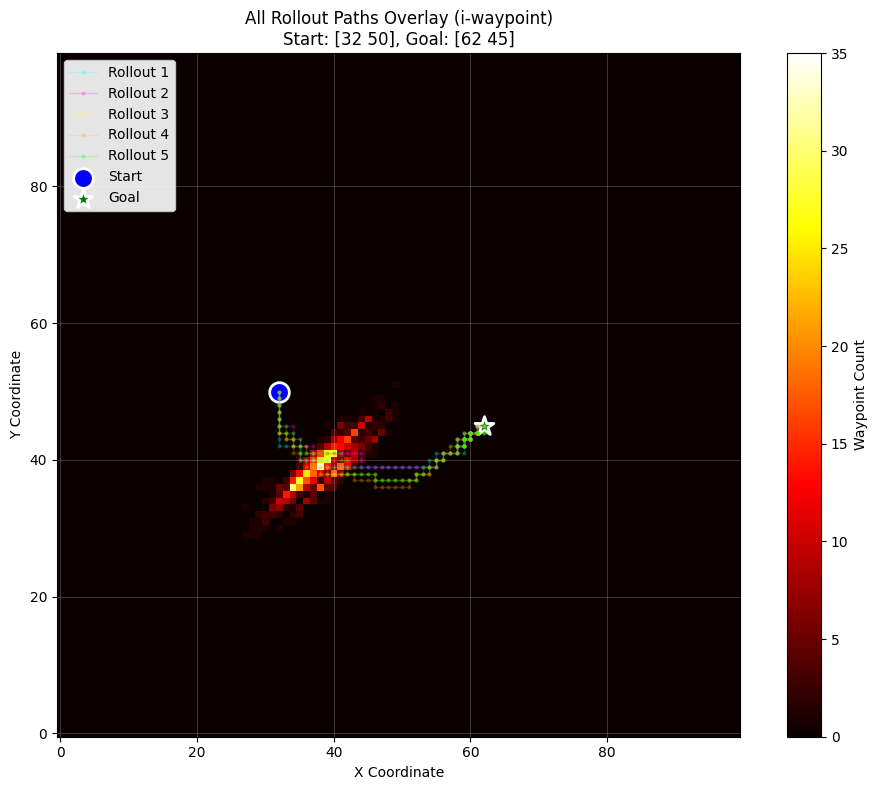

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 100))

In [40]:

# start_state = np.array([10, 10])
# end_state = np.array([80, 80])
start_state = np.random.randint(20, 80, (2,))
end_state = np.random.randint(20, 80, (2,))
waypoint_dist_vis2D(n_path, 'c', start_state=start_state, goal_state=end_state, M=10)
waypoint_dist_vis2D(n_path, 'c', start_state=start_state, goal_state=end_state, M=100)
waypoint_dist_vis2D(n_path, 'c', start_state=start_state, goal_state=end_state, M=1000)
waypoint_dist_vis2D(n_path, 'i', start_state=start_state, goal_state=end_state)

Generating waypoints: 100%|██████████| 1000/1000 [00:16<00:00, 60.03it/s]



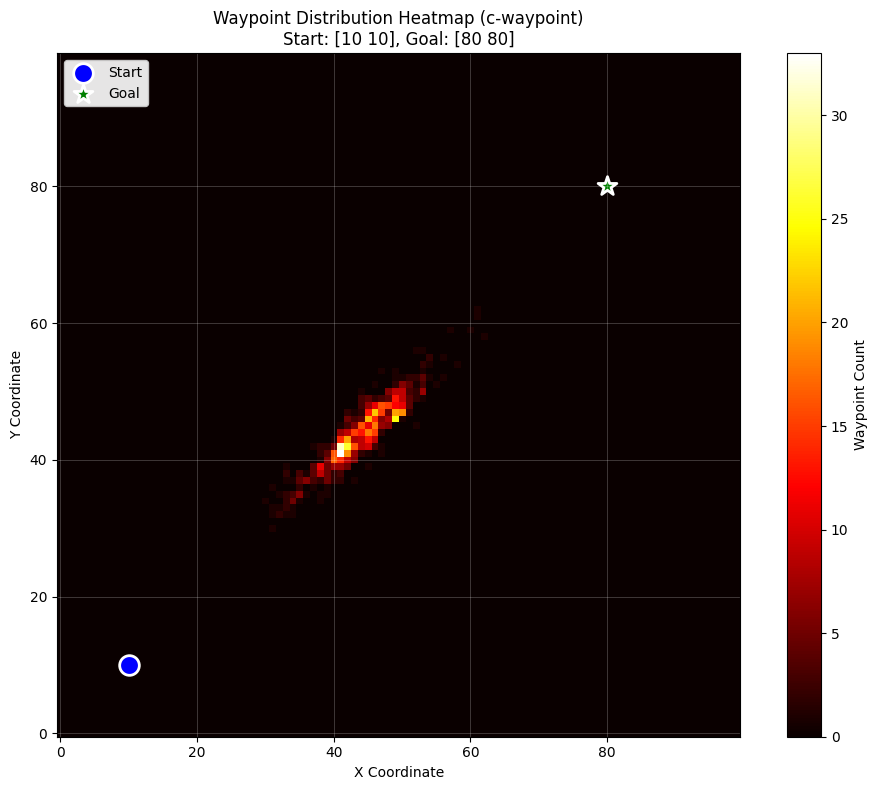

Generating rollouts for overlay: 100%|██████████| 5/5 [00:00<00:00, 35.11it/s]



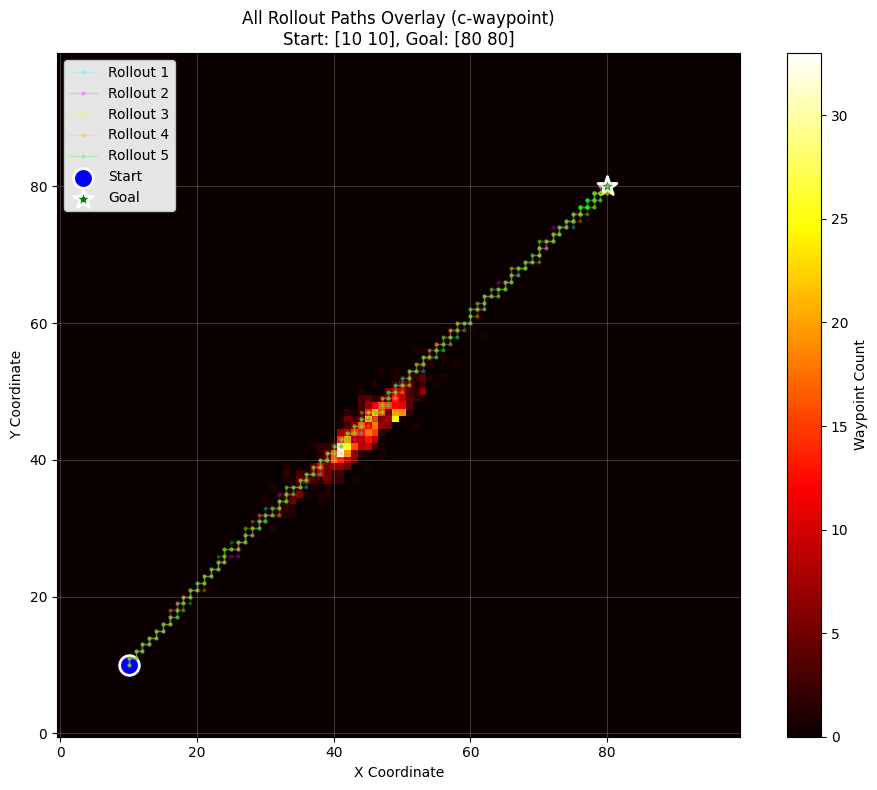

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 100))

In [32]:
waypoint_dist_vis2D(n_path, 'c', start_state=start_state, goal_state=end_state, M=100)


Generating waypoints: 100%|██████████| 1000/1000 [00:40<00:00, 24.40it/s]



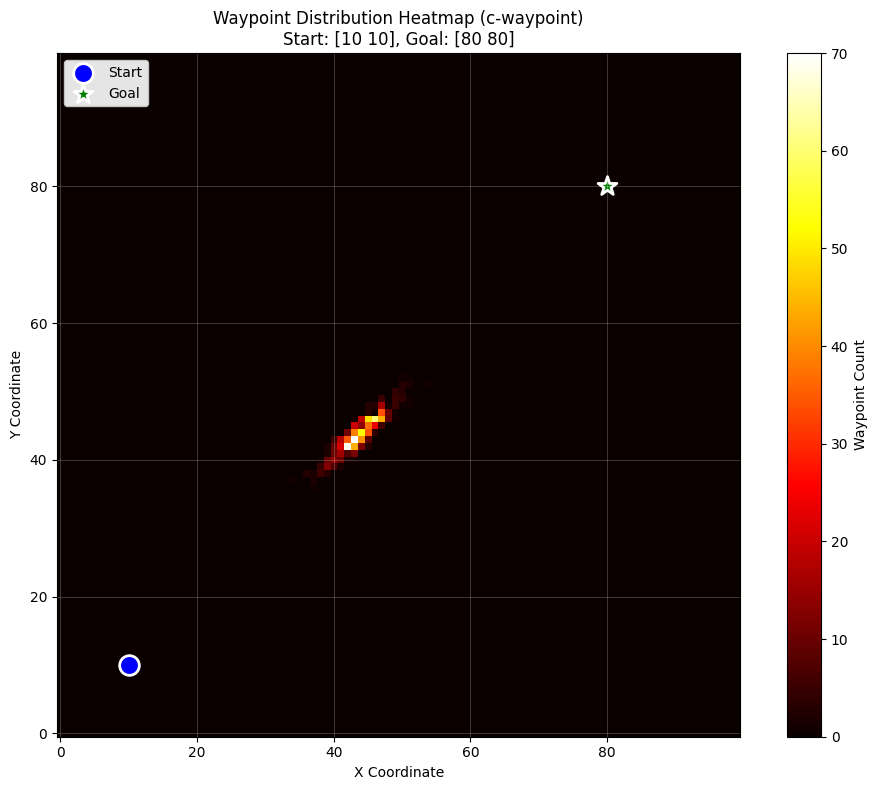

Generating rollouts for overlay: 100%|██████████| 5/5 [00:00<00:00, 37.60it/s]



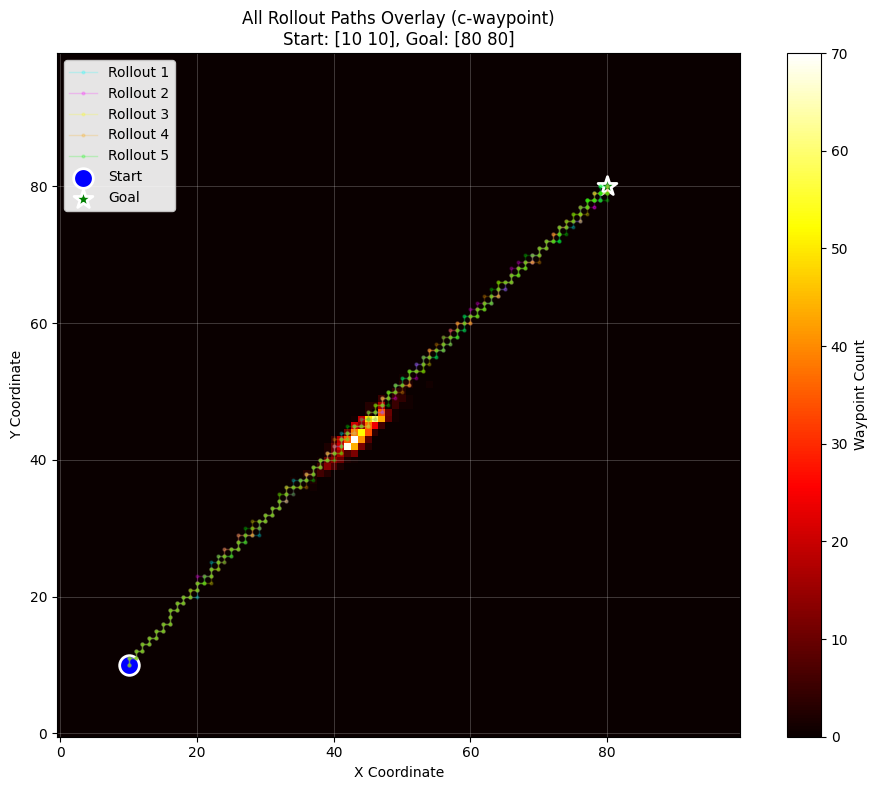

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 100))

In [33]:
waypoint_dist_vis2D(n_path, 'c', start_state=start_state, goal_state=end_state, M=1000)


Generating waypoints: 100%|██████████| 1000/1000 [00:12<00:00, 81.17it/s]


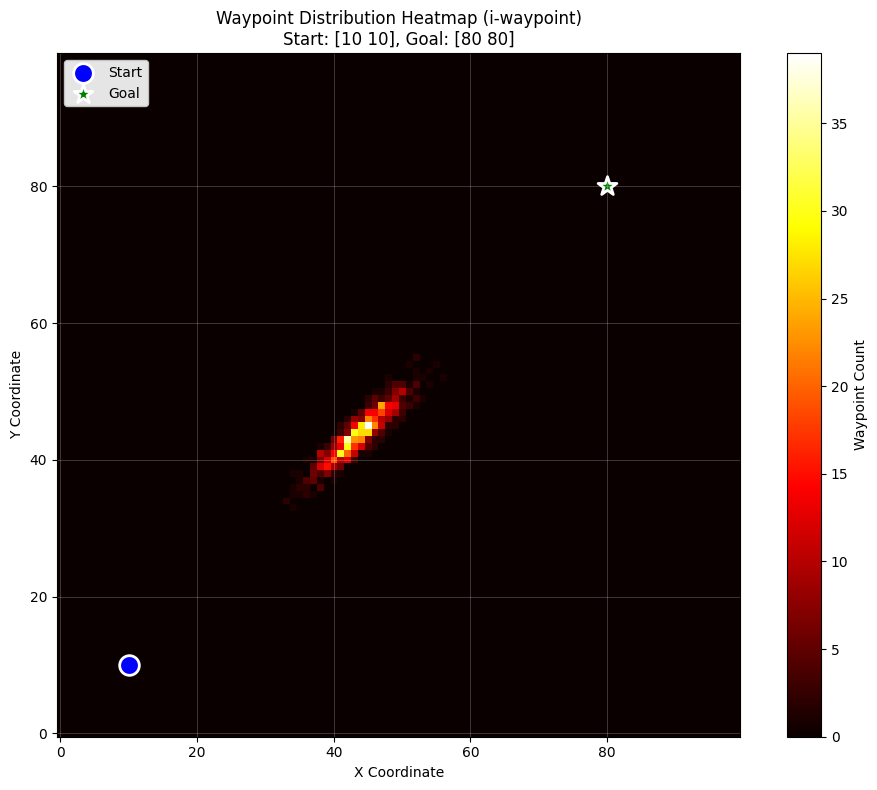

Generating rollouts for overlay: 100%|██████████| 5/5 [00:00<00:00, 35.47it/s]



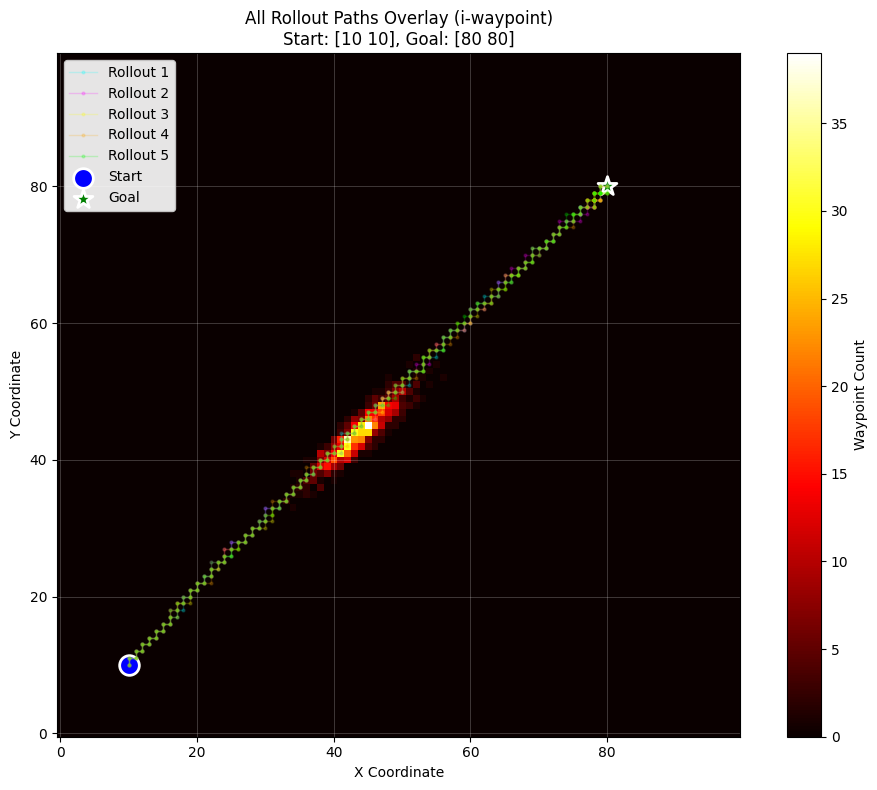

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 100))

In [34]:

waypoint_dist_vis2D(n_path, 'i', start_state=start_state, goal_state=end_state)



In [35]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def vis_emb_tsne(path):
    model = load_model(path + '/model.pt', verbose=False)
    config = model['config']
    env = GridworldProblem(config.env.K, config.env.N, config.env.O, config.env.r, config.seed)
    # start_state, goal_state = env.reset()
    def s_encoder(state):
        """Encode state: A @ psi(state)"""
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            emb = model['psi_net'](state_tensor).squeeze(0).numpy()
            return model['A_np'] @ emb
    
    def g_encoder(state):
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            emb = model['psi_net'](state_tensor).squeeze(0).numpy()
            return emb
    policy = GreedyPolicy(env, s_encoder, model['config']['eval']['temperature'])
    # build state buffer first 
        
    state_buffer = []
    while len(state_buffer) < config.training.buffer_size:
        start = np.random.randint(0, config.env.K, size=(config.env.N,))
        goal = np.random.randint(0, config.env.K, size=(config.env.N,))
        planner = WaypointPlanner(start, goal, env, policy,
                        g_encoder, model['A_np'],
                        waypoint_type='n',
                        max_waypoints=0)
        rollout, length, success = planner.rollout(start, goal, max_steps=model['config']['eval']['max_steps'], num_waypoints=0, temperature=0.1)
        state_buffer.extend(rollout)
    emb_state_buffer = []
    for state in state_buffer:
        emb_state_buffer.append(g_encoder(state))
    
    # Convert embeddings to numpy array
    emb_array = np.array(emb_state_buffer)
    # emb_2d = emb_array[:, :2]  # Using first two dimensions for visualization

    # Apply t-SNE
    tsne = TSNE(n_components=3, random_state=42, perplexity=30)
    emb_3d = tsne.fit_transform(emb_array)

    # Visualize t-SNE embeddings
    # Create 3D scatter plot
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(emb_3d[:, 0], emb_3d[:, 1], emb_3d[:, 2], 
                        alpha=0.5, s=10, c=range(len(emb_3d)), cmap='viridis')
    
    ax.set_title('t-SNE 3D Visualization of State Embeddings')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    
    plt.colorbar(scatter, label='State Index')
    plt.tight_layout()
    plt.show()
    

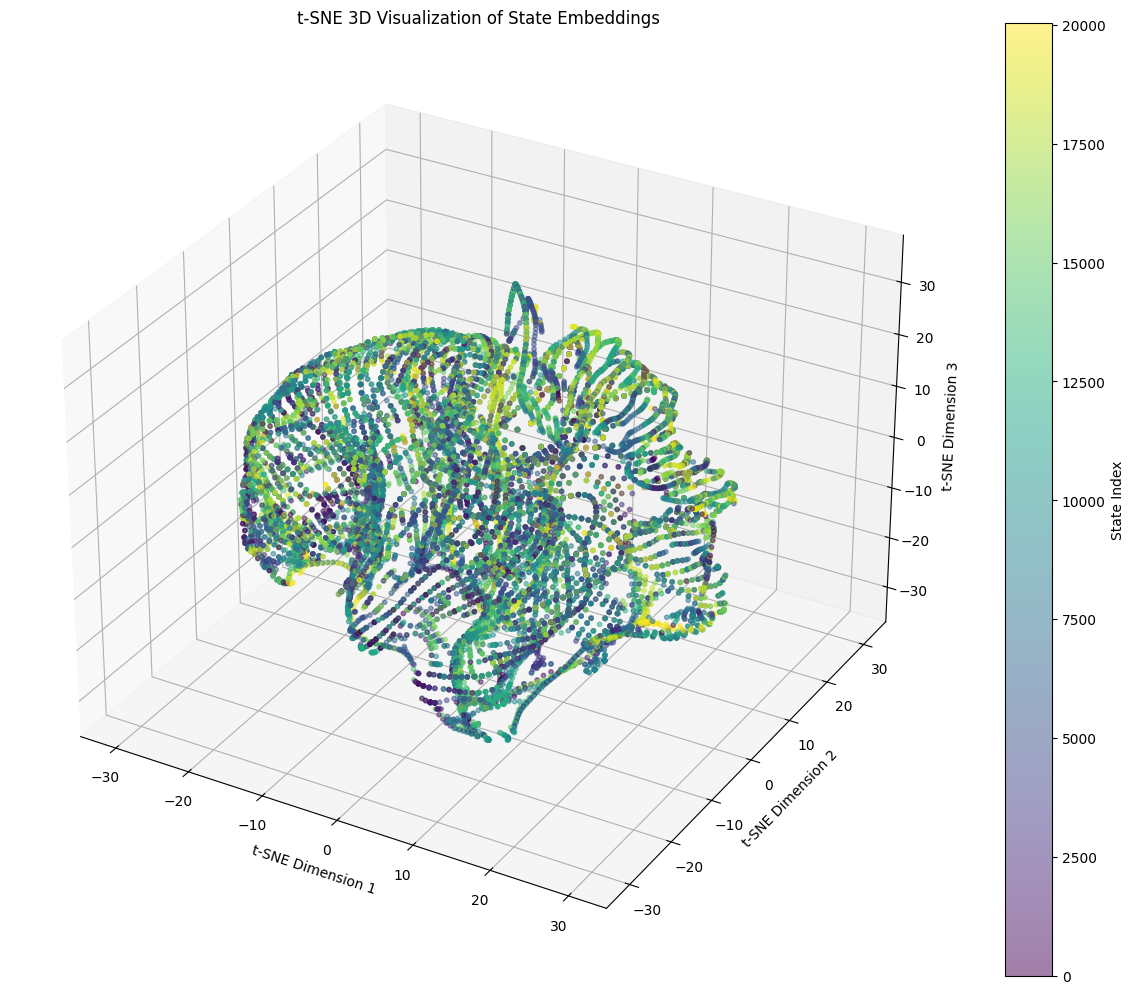

In [36]:
vis_emb_tsne(n_path)